# 03wk-2: 로지스틱 – 시그모이드, BCELoss, Adam, 로지스틱의 한계 및 극복

## 1. imports

In [5]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [6]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

## 3. 로지스틱 최초적합

### A. 로지스틱 모형

`-` $x$가 커질수록 (혹은 작아질수록) $y=1$이 잘나오는 모형은 아래와 같이
설계할 수 있음 \<— 외우세요!!!

-   $y_i \sim {\cal B}(\pi_i),\quad$ where
    $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)} = \frac{1}{1+\exp(-w_0-w_1x_i)}$

-   $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$

`-` 회귀모형과 로지스틱 모형의 비교

-   회귀모형: $y_i \sim {\cal N}(w_0+w_1x_i, \sigma^2)$[1]
-   로지스틱:
    $y_i \sim {\cal B}\big(\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}\big)$

`-` 우리가 예측하고 싶은것

-   회귀모형: 정규분포의 평균을 예측하고 싶음. 즉 $w_0+w_1x_i$를
    예측하고 싶음. 예측값으로는 $\hat{w}_0 + \hat{w}_1x_i$를 사용!
-   로지스틱: 베르누이의 평균을 예측하고 싶음. 즉
    $\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$를 예측하고 싶음.
    예측값으로는
    $\frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}$를
    사용!

### B. 데이터

[1] 원래는 이렇게 썼었지..
$y_i = w_0 + w_1x_i + \epsilon_i \quad \epsilon_i \sim {\cal N}(0,\sigma^2)$

In [7]:
## toy data
torch.manual_seed(43052)
x = torch.linspace(-1,1,2000).reshape(2000,1)
w0,w1 = -1, 5   ## True parameters
prob = torch.exp(w0+w1*x) / (1+torch.exp(w0+w1*x))  ## True probabilities
y = torch.bernoulli(prob)   ## 베르누이 확률분포에 의해 각 데이터포인트를 독립시행

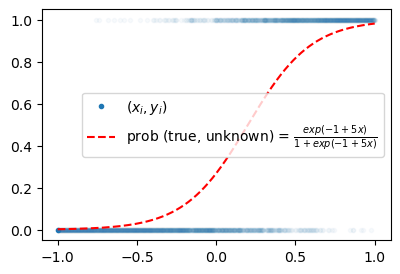

In [4]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'.',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.legend()

### C. Step1: net 설계 (모델링)

`-` 최초의 곡선을 그려보자.

-   최초의직선: $\hat{y}_i= \hat{w}_0+\hat{w}_1x_i$ 에서 아무
    $\hat{w}_0$, $\hat{w}_1$ 을 설정하면 된다.
-   최초의곡선:
    $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$
    에서 아무 $\hat{w}_0$, $\hat{w}_1$ 을 설정하면 된다.

> **Note**
>
> 일단은 초기 설정값을 $\hat{w}_0 = -0.8$, $\hat{w}_1 = -0.3$ 으로 하자.
> (실제값은 $w_0=-1$, $w_1=5$ 이다)

`# 방법1` – l1, sigmoid

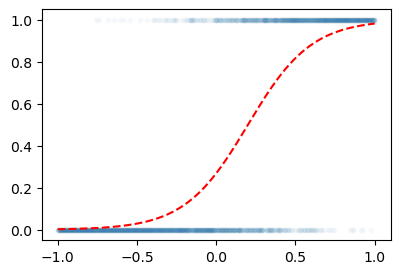

In [5]:
## w0hat과 w1hat을 찾으면 됨.
w0hat = 0.2
w1hat = 4

yhat = torch.exp(w0hat + w1hat*x)/(1+torch.exp(w0hat + w1hat*x))    # 1/(1+torch.exp(-w0hat - w1hat*x))

plt.plot(x, y, '.', alpha = 0.03)
plt.plot(x, prob, '--r')

> 이걸 `torch`만 써서 선형변환도 해보자.

In [6]:
linr = torch.nn.Linear(1, 1)
linr.weight.data
linr(x)

tensor([[ 0.6311],
        [ 0.6304],
        [ 0.6297],
        ...,
        [-0.6902],
        [-0.6909],
        [-0.6916]], grad_fn=<AddmmBackward0>)

In [7]:
def sigmoid(x) :
    return 1 / (1+torch.exp(-x))

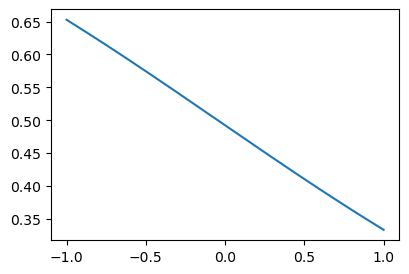

In [8]:
yhat = sigmoid(linr(x))
plt.plot(x, yhat.data)  ## 단순 선형 함수의 형태

> 해당 값은 `linr.weight.data * x + linr.bias.data`와 동일함

In [9]:
linr.weight.data = torch.tensor([[10.0]])
linr.bias.data = torch.tensor([-4.0])

`-` 정리

In [10]:
l1 = torch.nn.Linear(1, 1) ## input, output, bias = True. 파라미터 시작 값은 무작위
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])

def sigmoid(x) :
    return 1 / (1+torch.exp(-x))

## yhat = torch.exp(l1(x)) / (1 + torch.exp(l1(x)))
yhat = sigmoid(l1(x))

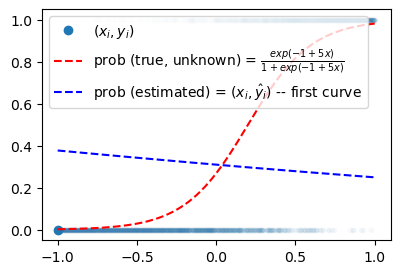

In [11]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,sigmoid(l1(x)).data,'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
## 이거 곡선 맞음. 계수값이 너무 작아서 그럼
plt.legend()

`# 방법 2` - `l1`, `a1`

In [13]:
l1 = torch.nn.Linear(1, 1)
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])

In [14]:
a1 = torch.nn.Sigmoid() ## 그냥 시그모이드를 만드는 것

In [15]:
sigmoid(l1(x)), a1(l1(x))

(tensor([[0.3775],
         [0.3775],
         [0.3774],
         ...,
         [0.2499],
         [0.2498],
         [0.2497]], grad_fn=<MulBackward0>),
 tensor([[0.3775],
         [0.3775],
         [0.3774],
         ...,
         [0.2499],
         [0.2498],
         [0.2497]], grad_fn=<SigmoidBackward0>))

> 똑같은 방법임...

`-` 지금까지의 구현 확인

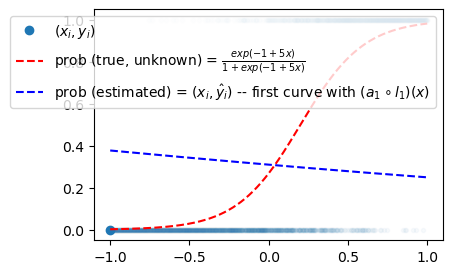

In [16]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,a1(l1(x)).data,'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve with $(a_1 \circ l_1)(x)$")
plt.legend()

`# 방법3` - `l1`, `a1` 만들고 $\to$ `net`

`-` 관찰: 지금 아래의 구조이다.

$${\bf x} \overset{l_1}{\to} {\bf u} \overset{a_1}{\to} {\bf v} = \hat{\bf y}$$

`-` 소망: 함수 $l_1, a_1$ 의 합성을 하나로 묶어서

$$(a_1\circ l_1)({\bf x}) := net({\bf x})$$

이러한 기능을 하는 하나의 함수 $net$을 만들 수 없을까?

In [17]:
l1 = torch.nn.Linear(1,1)
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
a1 = torch.nn.Sigmoid()

net = torch.nn.Sequential(l1, a1)

In [18]:
net(x)

tensor([[0.3775],
        [0.3775],
        [0.3774],
        ...,
        [0.2499],
        [0.2498],
        [0.2497]], grad_fn=<SigmoidBackward0>)

`-` 굳이 `net`을 왜 만드느냐?

In [19]:
net

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)

In [ ]:
net[0]  ## 회귀분석에서의 네트워크와 동일. torch.nn.Linear()

Linear(in_features=1, out_features=1, bias=True)

In [22]:
net[1]  ## 아까 시그모이드 함수 그거임

Sigmoid()

In [25]:
(l1 == net[0]) and (a1 == net[1])

True

In [28]:
(id(l1) == id(net[0])) and (id(a1) == id(net[1])) ## 같은 메모리 공간을 점유함

True

> `net[0]`는 `l1`, `net[1]`은 `a1`임

> 처음 회귀분석을 할 때의 구조와 거의 동일하게 만들어줄 수 있기 때문임. 원래 `net`은 `yhat`을 만들기 위한 거였음 ㅇㅇ $\to$ `torch.nn.Linear()`

`# 방법 4` - `net`을 바로 만들기

In [31]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 1),  ## l1이랑 동일한 오브젝트
    torch.nn.Sigmoid()  ## 얘도 당연함
)

## l1이랑 net[0]는 동일한 오브젝트이므로 초기값 할당도 가능함
net[0].weight.data = torch.tensor([[-0.3]])
net[0].bias.data = torch.tensor([-0.8])

yhat = net(x)

### D. Step 1 ~ 4

`-` 최초의 곡선

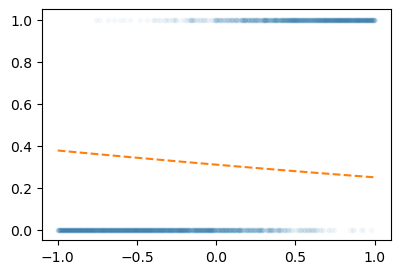

In [34]:
plt.plot(x, y, '.', alpha = 0.03)
plt.plot(x, net(x).data, '--')

* 전체 과정 : `net` 선언하는 것만 조금 달라짐

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
    torch.nn.Sigmoid()
)
net[0].weight.data = torch.tensor([[-0.3]]) ## What = torch.tensor([[a], [b]], requires_grad = True)
net[0].bias.data = torch.tensor([-0.8])

optimizr = torch.optim.SGD(net.parameters(), lr = 0.25)

#---#
for epoc in range(100) :
    ## 1
    yhat = net(x)
    ## 2
    loss = torch.mean((y - yhat)**2) ## loss_fn = torch.nn.MSELoss; loss = loss_fn(yhat, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step() ## What.data = What.data - alpha*What.grad
    optimizr.zero_grad()    ## What.grad = None

Text(0.5, 1.0, 'after 100 epochs')

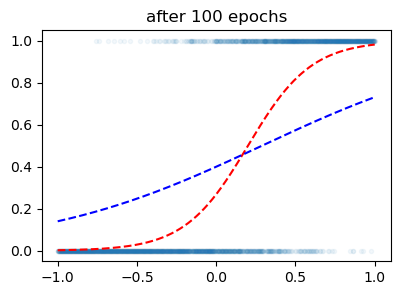

In [36]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,prob,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

In [37]:
for epoc in range(4900):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

Text(0.5, 1.0, 'after 5000 epochs')

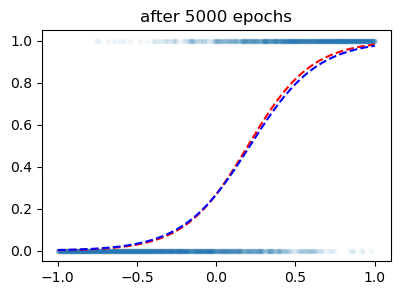

In [38]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,prob,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 5000 epochs')

> 잘 된 것 같음?

## 3. 학습과정 시각화 및 문제 인식

### A. 시각화를 위한 준비

In [8]:
def plot_loss(loss_fn, ax=None, Wstar=[-1,5]):
    w0hat,w1hat =torch.meshgrid(torch.arange(-10,3,0.1),torch.arange(-1,10,0.1),indexing='ij')
    w0hat = w0hat.reshape(-1)
    w1hat = w1hat.reshape(-1)
    def l(w0hat,w1hat):
        yhat = torch.exp(w0hat+w1hat*x)/(1+torch.exp(w0hat+w1hat*x))
        return loss_fn(yhat,y) 
    loss = list(map(l,w0hat,w1hat))
    #---#
    if ax is None: 
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(w0hat,w1hat,loss,s=0.001) 
    ax.scatter(w0hat[::20],w1hat[::20],loss[::20],s=0.1,color='C0') 
    w0star,w1star = np.array(Wstar).reshape(-1)
    ax.scatter(w0star,w1star,l(w0star,w1star),s=200,marker='*',color='red',label=f"W=[{w0star:.1f},{w1star:.1f}]")
    #---#
    ax.elev = 15
    ax.dist = -20
    ax.azim = 75    
    ax.legend()
    ax.set_xlabel(r'$w_0$')  # x축 레이블 설정
    ax.set_ylabel(r'$w_1$')  # y축 레이블 설정
    ax.set_xticks([-10,-5,0])  # x축 틱 간격 설정
    ax.set_yticks([-10,0,10])  # y축 틱 간격 설정

In [9]:
def _learn_and_record(net, loss_fn, optimizr):
    yhat_history = [] 
    loss_history = []
    What_history = []
    Whatgrad_history = []
    What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
    for epoc in range(100): 
        ## step1 
        yhat = net(x)
        ## step2 
        loss = loss_fn(yhat,y)
        ## step3
        loss.backward() 
        ## step4 
        optimizr.step()
        ## record 
        if epoc % 5 ==0: 
            yhat_history.append(yhat.reshape(-1).data.tolist())
            loss_history.append(loss.item())
            What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
            Whatgrad_history.append([net[0].bias.grad.item(), net[0].weight.grad.item()])
        optimizr.zero_grad() 
        
    return yhat_history, loss_history, What_history, Whatgrad_history
    
def show_animation(net, loss_fn, optimizr):
    yhat_history,loss_history,What_history,Whatgrad_history = _learn_and_record(net,loss_fn,optimizr)
    
    fig = plt.figure(figsize=(7.5,3.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ## ax1: 왼쪽그림 
    ax1.scatter(x,y,alpha=0.01)
    ax1.scatter(x[0],y[0],color='C0',label=r"observed data = $(x_i,y_i)$")
    ax1.plot(x,prob,'--',label=r"prob (true) = $(x_i,\frac{exp(-1+5x_i)}{1+exp(-1+5x_i)})$")    
    line, = ax1.plot(x,yhat_history[0],'--',label=r"prob (estimated) = $(x_i,\hat{y}_i)$") 
    ax1.legend()
    ## ax2: 오른쪽그림 
    plot_loss(loss_fn,ax2)
    ax2.scatter(np.array(What_history)[0,0],np.array(What_history)[0,1],loss_history[0],color='blue',s=200,marker='*')    
    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        w0hat = np.array(What_history)[epoc,0]
        w1hat = np.array(What_history)[epoc,1]
        w0hatgrad = np.array(Whatgrad_history)[epoc,0]
        w1hatgrad = np.array(Whatgrad_history)[epoc,1]
        ax2.scatter(w0hat,w1hat,loss_history[epoc],color='grey')
        ax2.set_title(f"What.grad=[{w0hatgrad:.4f},{w1hatgrad:.4f}]",y=0.8)
        fig.suptitle(f"epoch={epoc*5} // What=[{w0hat:.2f},{w1hat:.2f}] // Loss={loss_fn.__class__.__name__} // Opt={optimizr.__class__.__name__}")
        return line
    ani = animation.FuncAnimation(fig, animate, frames=20)    
    plt.close()
    return ani

In [10]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

`-` 함수 사용법

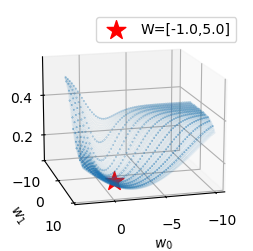

In [ ]:
loss_fn = torch.nn.MSELoss()    ## MSELoss function
plot_loss(loss_fn)  ## 어떠한 함수를 전달하면 그 함수에 해당하는 곡면 이미지를 산출

In [1]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1, 1),
#     torch.nn.Sigmoid()
# )

# net[0].weight.data = torch.tensor([[-0.8]])
# net[0].bias.data = torch.tensor([-0.3])

# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(), lr = 2.5)

# show_animation(net, loss_fn, optimizr)

### B. 좋은 초기값

In [2]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-0.8])
# net[0].weight.data = torch.tensor([[-0.3]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

### C. 가능성 있는 초기값

In [3]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-3.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

### D. 최악의 초기값

In [4]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-10.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

* 만약 loss_fn이 convex하지 않거나, local minimum을 가진다면? -> 전역 최소값을 찾기 어려움.

`-` 해결하는 접근법

* 컴공스타일 : 에폭을 늘려볼까? -> 초기값을 계속 달리해서 많이 계산해보자.
* 산공스타일 : 옵티마이저를 바꿔볼까? -> 경사하강법이 아닌 다른 최적화 모듈을 사용

## 5. 손실함수의 개선

### A. BCE Loss Binary Cross Entropy를 이용하여 학습

`-` BCE loss라는게 있음.

-   $loss= - \sum_{i=1}^{n} \big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$ -> MLE 구하는 과정...
-   <https://en.wikipedia.org/wiki/Cross-entropy>

In [11]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
    torch.nn.Sigmoid()
)
l1, a1 = net    ## 튜플 언패킹
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)

#---#
for epoc in range(100) :
    ## 1
    yhat = net(x)
    ## 2
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

Text(0.5, 1.0, 'after 100 epochs')

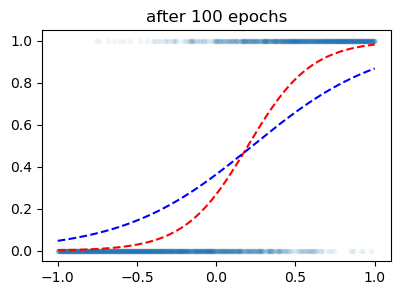

In [12]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,prob,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

> 같은 100에폭인데 훨씬 잘 수렴...

`-` loss 수식을 못외우겠으면?

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net 
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
loss_fn = torch.nn.BCELoss()    ## MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) # yhat부터 써야함
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

Text(0.5, 1.0, 'after 100 epochs')

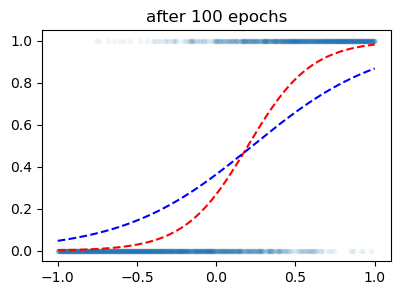

In [14]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,prob,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

### B. Loss Function 시각화

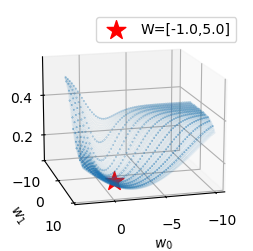

In [15]:
plot_loss(torch.nn.MSELoss())

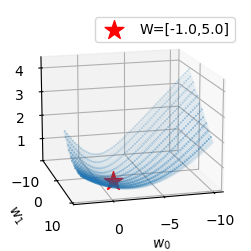

In [16]:
plot_loss(torch.nn.BCELoss())

`-` 비교해보자

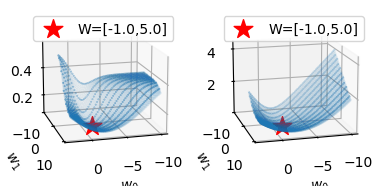

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
plot_loss(torch.nn.MSELoss(),ax1)
plot_loss(torch.nn.BCELoss(),ax2)

### C. 학습과정 시각화 - 좋은 초기값

`-` MSELoss

In [20]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-0.8])
# net[0].weight.data = torch.tensor([[-0.3]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [21]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-0.8])
# net[0].weight.data = torch.tensor([[-0.3]])
# loss_fn = torch.nn.BCELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

> 훨씬 빠름

### D. 학습과정 시각화 - 가능성 있는 초기값

In [ ]:
# ## MSELoss
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-3.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

In [25]:
# ## BCELoss
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-3.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.BCELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

### E. 학습과정 시각화 - 최악의 초기값

In [28]:
# ## MSELoss
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-10.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

In [29]:
# ## BCELoss
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-10.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.BCELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

> 확실히 잘 최적화됨

## 6. 옵티마이저의 개선

### A. 학습과정 시각화 - 좋은 초기값

`-` MSELoss + SGD

In [31]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-0.8470])
# net[0].weight.data = torch.tensor([[-0.3467]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [33]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-0.8])
# net[0].weight.data = torch.tensor([[-0.3]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

> 개빠름

### B. 학습과정 시각화 – 가능성 있는 초기값

`-` MSELoss + SGD

In [36]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-3.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [38]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-3.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
# #---#
# show_animation(net,loss_fn,optimizr)

## C. 학습과정 시각화 – 최악의 초기값

`-` MSELoss + SGD

In [39]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(1,1),
#     torch.nn.Sigmoid()
# ) 
# net[0].bias.data = torch.tensor([-10.0])
# net[0].weight.data = torch.tensor([[-1.0]])
# loss_fn = torch.nn.MSELoss()
# optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 
# #---#
# show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [40]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

> 그냥 잘함. 최적화 잘하고 싶으시다면 그냥 아담 쓰시면 돼요. 네.
>
> SGD는 로컬 미니멈에도 잘 빠짐, Adam은 전역 최소값을 더 잘 찾음

### D. 참고자료

<https://www.youtube.com/watch?v=MD2fYip6QsQ>

-   11:50 – Momentum
-   12:30 – RMSprop
-   15:55 – Adam

## 7. 로지스틱의 한계

In [ ]:
## step1 -- 최초의 곡선???
## step2 -- Loss 건드리기
## step3
## step4 -- optimizr 건드리기 -> 아담 말고는 안씀!

> 값이 커짐에 따라 0, 1이 나올 확률의 변화가 일관적일 때만 유용함

### A. 신문기사 (데이터의 모티브)

`-` [스펙이 높아도 취업이 안된다고
합니다..](https://www.joongang.co.kr/article/23637092#home)

**중소·지방 기업 “뽑아봤자 그만두니까”**

중소기업 관계자들은 고스펙 지원자를 꺼리는 이유로 높은 퇴직률을 꼽는다.
여건이 좋은 대기업으로 이직하거나 회사를 관두는 경우가 많다는
하소연이다. 고용정보원이 지난 3일 공개한 자료에 따르면 중소기업
청년취업자 가운데 49.5%가 2년 내에 회사를 그만두는 것으로 나타났다.

중소 IT업체 관계자는 “기업 입장에서 가장 뼈아픈 게 신입사원이 그만둬서
새로 뽑는 일”이라며 “명문대 나온 스펙 좋은 지원자를 뽑아놔도 1년을
채우지 않고 그만두는 사원이 대부분이라 우리도 눈을 낮춰 사람을 뽑는다”고
말했다.

### B. 가짜데이터

In [41]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
df

,x,prob,y
0,-1.000000,0.000045,0.0
1,-0.998999,0.000046,0.0
2,-0.997999,0.000047,0.0
3,-0.996998,0.000047,0.0
4,-0.995998,0.000048,0.0
...,...,...,...
1995,0.995998,0.505002,0.0
1996,0.996998,0.503752,0.0
1997,0.997999,0.502501,0.0
1998,0.998999,0.501251,1.0


In [42]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

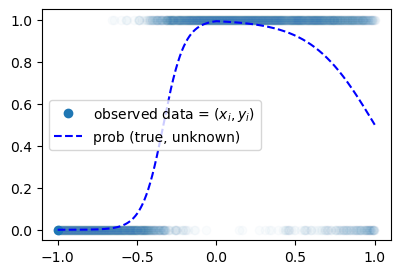

In [43]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

### C. 로지스틱으로 적합

In [44]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() ## 통계쪽
optimizr = torch.optim.Adam(net.parameters()) ## 산공쪽
#---# 
for epoc in range(5000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

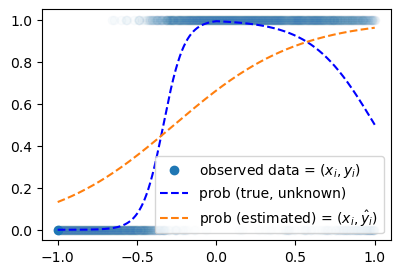

In [45]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data, '--', label= r"prob (estimated) = $(x_i,\hat{y}_i)$")
plt.legend()

> 무슨 수를 써서도, epoch을 10억번 돌려도 구조적으로 못맞춤

## 8. 로지스틱의 한계 극복

### A. 아이디어

`-` 시그모이드를 넣기 전의 상태가 직선이 아니라 꺾이는 형태여야 한다. : step 1 자체, 모델링이 틀린거임

In [46]:
a = torch.nn.Sigmoid()

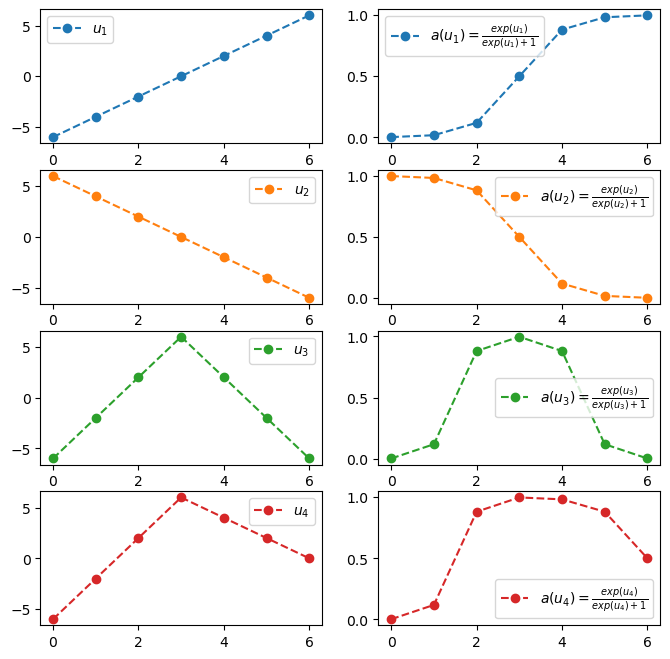

In [47]:
fig,ax = plt.subplots(4,2,figsize=(8,8))
u1 = torch.tensor([-6,-4,-2,0,2,4,6])
u2 = torch.tensor([6,4,2,0,-2,-4,-6])
u3 = torch.tensor([-6,-2,2,6,2,-2,-6])
u4 = torch.tensor([-6,-2,2,6,4,2,0])
ax[0,0].plot(u1,'--o',color='C0',label = r"$u_1$")
ax[0,0].legend()
ax[0,1].plot(a(u1),'--o',color='C0',label = r"$a(u_1)=\frac{exp(u_1)}{exp(u_1)+1}$")
ax[0,1].legend()
ax[1,0].plot(u2,'--o',color='C1',label = r"$u_2$")
ax[1,0].legend()
ax[1,1].plot(a(u2),'--o',color='C1',label = r"$a(u_2)=\frac{exp(u_2)}{exp(u_2)+1}$")
ax[1,1].legend()
ax[2,0].plot(u3,'--o',color='C2', label = r"$u_3$")
ax[2,0].legend()
ax[2,1].plot(a(u3),'--o',color='C2', label = r"$a(u_3)=\frac{exp(u_3)}{exp(u_3)+1}$")
ax[2,1].legend()
ax[3,0].plot(u4,'--o',color='C3', label = r"$u_4$")
ax[3,0].legend()
ax[3,1].plot(a(u4),'--o',color='C3', label = r"$a(u_4)=\frac{exp(u_4)}{exp(u_4)+1}$")
ax[3,1].legend()

### B. 꺾인 그래프를 만드는 방법

`-` 로지스틱의 한계를 극복하기 위해서는 시그모이드를 취하기 전 꺾인 그래프 모양을 만드는 기술이 있어야 함.